# Training Mask R-CNN model with custom dataset

In [1]:
# define the dataset directory path in google drive
dataset_dir = '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset'

## Clone Mask R-CNN repository

In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


## Specify Tensorflow and Keras version (*important*)

In [3]:
!pip install keras==2.2.5
%tensorflow_version 1.x
import tensorflow
from tensorflow import keras

TensorFlow 1.x selected.


In [4]:
import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Custom Dataset

In [5]:
# dataset object
class taxiDataset(Dataset):
  
  # load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
    """
    Load the dataset definitions : image id, image path and annotation path
    """

    # define one class to train
    self.add_class("dataset", 1, "taxi")
    
    # define image and annotation locations
    if is_train==True:
      # define location for training set
      images_dir = dataset_dir + '/train/Taxi/images/'
      annotations_dir = dataset_dir + '/train/Taxi/annotations/'
    else :
      # define location for test set
      images_dir = dataset_dir + '/test/Taxi/images/'
      annotations_dir = dataset_dir + '/test/Taxi/annotations/'

    # find all images
    for filename in os.listdir(images_dir):

      # extract image id
      image_id = filename[:-4]
      
      # extract paths
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.txt'

      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

  def extract_boxes(self, filename):
    """
    - extract bounding boxes from an annotation file
    """
    
    # define list of boxes
    boxes = []

    # open the txt annotation file and read the information
    with open(filename) as file:
      temp = file.read().splitlines()

    # extract each box from each line
    for line in temp:
      box = list(map(float, line.split()[1:]))
      boxes.append(box)

    return boxes
  
  def load_mask(self, image_id):
    """
    load the mask of an image
    """

    # get details of image
    info = self.image_info[image_id]

    # define image file location
    img_path = info['path']

    # load image and get its dimensions
    img = load_img(img_path)
    w = img.width
    h = img.height
    
    # define annotation file location
    ann_path = info['annotation']

    # load boxes
    boxes = self.extract_boxes(ann_path)

    # create mask manually 
    # since out dataset has only bounding boxes 
    # we'll then generate rectangle mask from the boxes

    # create one array for all masks, each on a different channel
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')

    # create masks and class id
    class_ids = []
    for i,box in enumerate(boxes):
      row_s, row_e = int(box[1]), int(box[3])
      col_s, col_e = int(box[0]), int(box[2])
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('taxi'))
    
    return masks, np.asarray(class_ids, dtype='int32')
  
  def image_reference(self, image_id):
    """
    load an image reference
    """
    info = self.image_info[image_id]
    return info['path']

In [6]:
# create train set
train_set = taxiDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()

# create test set
test_set = taxiDataset()
test_set.load_dataset(dataset_dir, is_train=False)
test_set.prepare()

print('Train : ', len(train_set.image_ids))
print('Test : ', len(test_set.image_ids))

Train :  100
Test :  20


## Create Configuration

In [7]:
# define a configuration for the model
class taxiConfig(Config):
  
  # define the name of the configuration
  NAME = 'taxi_cfg'

  # number of classes (background + taxi)
  NUM_CLASSES = 1 + 1

  # number of training steps per epoch
  STEPS_PER_EPOCH = 10

In [8]:
config = taxiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Build Mast R-CNN model

In [9]:
# define model
model = MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


## Load pre-trained weights into the model

In [10]:
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Train the model

In [11]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/taxi_cfg20210127T1653/mask_rcnn_taxi_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
10/10 [==============================] - 74s 7s/step - loss: 2.9144 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 1.2216 - mrcnn_mask_loss: 1.2259 - val_loss: 1.5676 - val_rpn_class_loss: 0.0231 - val_rpn_bbox_loss: 0.1876 - val_mrcnn_class_loss: 0.0627 - val_mrcnn_bbox_loss: 0.7724 - val_mrcnn_mask_loss: 0.5218

Epoch 2/10
10/10 [==============================] - 37s 4s/step - loss: 1.4770 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.2923 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.5888 - mrcnn_mask_loss: 0.4888 - val_loss: 1.4773 - val_rpn_class_loss: 0.0203 - val_rpn_bbox_loss: 0.2872 - val_mrcnn_class_loss: 0.0333 - val_mrcnn_bbox_loss: 0.6900 - val_mrcnn_mask_loss: 0.4466
Epoch 3/10
10/10 [==============================] - 36s 4s/step - loss: 1.2283 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.4535 - mrcnn_mask_loss: 0.4095 - val_loss: 1.1828 - val_rpn_class_loss: 0

# Make detection from trained model

In [31]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.model import log
from mrcnn import visualize
import matplotlib.pyplot as plt
import random

## Create prediction configuration

In [ ]:
class PredictionConfig(Config):
    NAME = 'taxi_cfg'
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = PredictionConfig()

## Recreate the model and load trained weights

In [44]:
# Recreate the model in inference mode
model = MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/Mask_RCNN/logs/taxi_cfg20210127T1653/mask_rcnn_taxi_cfg_0010.h5
Re-starting from epoch 10


## get ground truth from random image

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  359.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


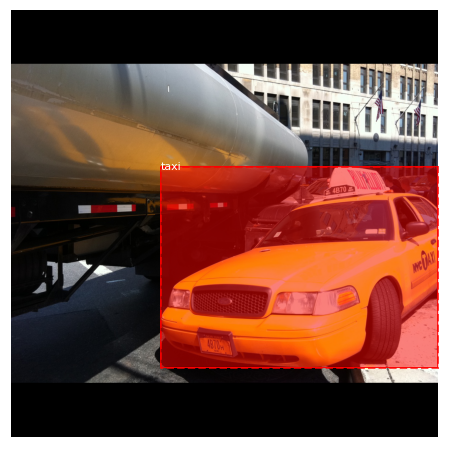

In [35]:
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

## detection on the image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


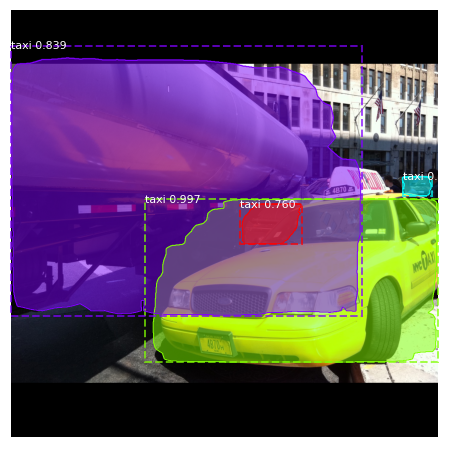

In [37]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], figsize=(8, 8))

# Model Evaluation

In [43]:
APs = []
for image_id in test_set.image_ids:

  # load ground truth
  image, _, gt_class_id, gt_bbox, gt_mask = load_image_gt(test_set, config, image_id, use_mini_mask=False)

  # convert pixel values
  scaled_image = mold_image(image, config)

  # convert into one sample batch
  sample = np.expand_dims(scaled_image, 0)

  # make prediction
  results = model.detect(sample, verbose=0)

  # extract results for first sample
  r = results[0]

  # calculate statistics
  AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                 r['rois'], r['class_ids'], r['scores'], r['masks'])
  
  # append to APs
  APs.append(AP)

# calculate mean AP 
mAP = np.mean(APs)

print('Model mAP : ', mAP)

Model mAP :  0.7950000013411046
